In [1]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [2]:
from malaya_speech.train.model import aligner, fastvc, fastspeech
import malaya_speech
import tensorflow as tf
import matplotlib.pyplot as plt






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
from scipy.stats import betabinom
import numpy as np

def beta_binomial_prior_distribution(phoneme_count, mel_count, scaling_factor=1.0):
    x = np.arange(0, phoneme_count)
    mel_text_probs = []
    for i in range(1, mel_count + 1):
        a, b = scaling_factor * i, scaling_factor * (mel_count + 1 - i)
        mel_i_prob = betabinom(phoneme_count, a, b).pmf(x)
        mel_text_probs.append(mel_i_prob)
    return np.array(mel_text_probs)

attn_prior = np.expand_dims(beta_binomial_prior_distribution(50, 100), 0).astype(np.float32)
attn_prior.shape, attn_prior.min(), attn_prior.max()

((1, 100, 50), 4.968e-41, 0.6666667)

In [4]:
i = tf.placeholder(tf.int32, [None, None])
lens = tf.placeholder(tf.int32, [None])
mel = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
prior = tf.placeholder(tf.float32, [None, None, None])

In [5]:
encoder = aligner.AlignmentEncoder(vocab_size = 100, vocab_embedding = 512)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
attention_mask = tf.expand_dims(tf.math.not_equal(i, 0), -1)
attention_mask

<tf.Tensor 'ExpandDims:0' shape=(?, ?, 1) dtype=bool>

In [7]:
attn_soft, attn_logprob = encoder(mel, i, mask = attention_mask, attn_prior = prior)
attn_soft, attn_logprob

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'AlignmentEncoder/Softmax:0' shape=(?, 1, ?, ?) dtype=float32>,
 <tf.Tensor 'AlignmentEncoder/Identity:0' shape=(?, 1, ?, ?) dtype=float32>)

In [8]:
attn_hard = encoder.get_hard_attention(attn_soft, lens, mel_lengths)
attn_hard

<tf.Tensor 'PyFunc:0' shape=(?, 1, ?, ?) dtype=float32>

In [9]:
forwardsum_loss = aligner.forwardsum_loss(attn_logprob, lens, mel_lengths)
forwardsum_loss

Instructions for updating:
Use `tf.cast` instead.



<tf.Tensor 'truediv:0' shape=() dtype=float32>

In [10]:
bin_loss = aligner.bin_loss(attn_hard, attn_soft)
bin_loss

<tf.Tensor 'truediv_1:0' shape=() dtype=float32>

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-3).minimize(forwardsum_loss + bin_loss)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)

In [14]:
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [15]:
l_text = data['len_text_ids'][0,0]
l_mel = data['len_mel'][0,0]
l_text, l_mel

(72, 408)

In [16]:
prior_ = np.expand_dims(beta_binomial_prior_distribution(l_text, l_mel), 0).astype(np.float32)
prior_.shape

(1, 408, 72)

In [17]:
o = sess.run([attn_soft, attn_logprob], feed_dict = {i: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mel: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0],
                                                    prior: prior_})
o[0].shape, o[1].shape

((1, 1, 408, 72), (1, 1, 408, 72))

In [18]:
for no in range(200):
    o = sess.run([forwardsum_loss, bin_loss, optimizer], feed_dict = {i: data['text_ids'],
                                                        lens: data['len_text_ids'][:,0],
                                                        mel: data['mel'],
                                                        mel_lengths: data['len_mel'][:,0],
                                                        prior: prior_})
    print(no, o)

/Users/huseinzolkepli/Documents/malaya-speech/malaya_speech/train/model/aligner/model.py:20: RuntimeWarning: divide by zero encountered in log
  attn_map = np.log(attn_map)


0 [2063.8103, 2.2990923, None]
1 [2060.8247, 2.2980132, None]
2 [2056.2263, 2.2962835, None]
3 [2049.4294, 2.2934864, None]
4 [2040.027, 2.290047, None]
5 [2029.5034, 2.283527, None]
6 [2019.9266, 2.2654493, None]
7 [2011.5076, 2.2538977, None]
8 [1999.2281, 2.219731, None]
9 [1986.2776, 2.1822305, None]
10 [1972.8312, 2.1398208, None]
11 [1950.7552, 2.0664113, None]
12 [1925.9686, 1.9855087, None]
13 [1900.4688, 1.8933192, None]
14 [1870.2916, 1.7814972, None]
15 [1839.0175, 1.7257565, None]
16 [1815.3284, 1.669061, None]
17 [1794.2671, 1.617562, None]
18 [1776.5856, 1.5834988, None]
19 [1774.5529, 1.5556587, None]
20 [1743.9736, 1.544278, None]
21 [1718.282, 1.5281963, None]
22 [1705.8799, 1.5178617, None]
23 [1678.4879, 1.5032719, None]
24 [1669.0098, 1.4854486, None]
25 [1642.8765, 1.4694555, None]
26 [1628.4594, 1.454557, None]
27 [1602.9614, 1.4289554, None]
28 [1588.6158, 1.399158, None]
29 [1565.2682, 1.3699123, None]
30 [1551.0558, 1.3482428, None]
31 [1527.5813, 1.3207865, No

In [19]:
o = sess.run([attn_soft, attn_logprob, attn_hard], feed_dict = {i: data['text_ids'],
                                                    lens: data['len_text_ids'][:,0],
                                                    mel: data['mel'],
                                                    mel_lengths: data['len_mel'][:,0],
                                                    prior: prior_})
o[0].shape, o[1].shape, o[2].shape

((1, 1, 408, 72), (1, 1, 408, 72), (1, 1, 408, 72))

In [20]:
o[0][0,0].shape

(408, 72)

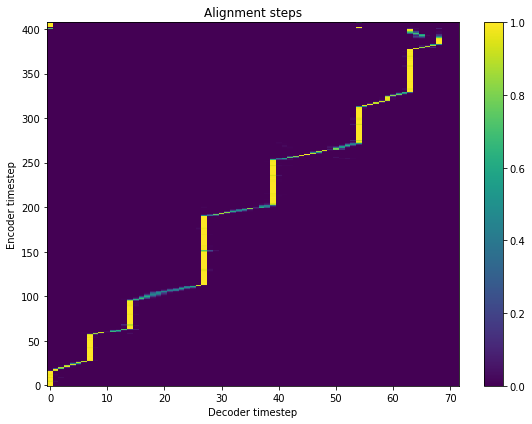

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[0][0,0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

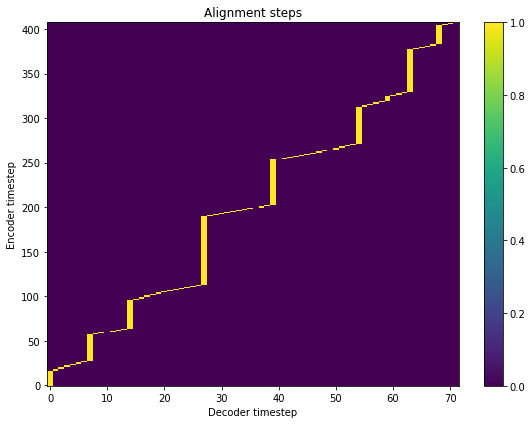

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[2][0,0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [23]:
tf.trainable_variables()

[<tf.Variable 'AlignmentEncoder/embeddings:0' shape=(100, 512) dtype=float32_ref>,
 <tf.Variable 'AlignmentEncoder/sequential/ConvNorm/conv1d/kernel:0' shape=(3, 512, 1024) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential/ConvNorm/conv1d/bias:0' shape=(1024,) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential/ConvNorm_1/conv1d_1/kernel:0' shape=(1, 1024, 80) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential/ConvNorm_1/conv1d_1/bias:0' shape=(80,) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential_1/ConvNorm/conv1d_2/kernel:0' shape=(3, 80, 160) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential_1/ConvNorm/conv1d_2/bias:0' shape=(160,) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential_1/ConvNorm_1/conv1d_3/kernel:0' shape=(1, 160, 80) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential_1/ConvNorm_1/conv1d_3/bias:0' shape=(80,) dtype=float32>,
 <tf.Variable 'AlignmentEncoder/sequential_1/ConvNorm_2/conv1d_4/kernel:0' shape=(1, 80

In [24]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'

In [25]:
!ls -lh test
!rm -rf test

total 30720
-rw-r--r--  1 huseinzolkepli  staff    77B Sep 23 21:12 checkpoint
-rw-r--r--  1 huseinzolkepli  staff   6.7M Sep 23 21:12 model.ckpt.data-00000-of-00001
-rw-r--r--  1 huseinzolkepli  staff   579B Sep 23 21:12 model.ckpt.index
-rw-r--r--  1 huseinzolkepli  staff   8.3M Sep 23 21:12 model.ckpt.meta
